In [431]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

train_csv = pd.read_csv('titanic/train.csv')
features_csv = pd.read_csv('all_features.csv')
labels_csv = pd.read_csv('all_labels.csv')
features_csv['Cabin'].value_counts() # 会增加187个维度，小于训练数据

features_csv = features_csv[features_csv.isna() == False]
features_csv.reset_index(drop=True)
labels_csv = labels_csv[labels_csv.isna() == False]
labels_csv.reset_index(drop=True)

,Survived
0,0
1,1
2,1
3,1
4,0
...,...
886,0
887,1
888,0
889,1


In [432]:
# 测试1：移除isAlone
# del features_csv['IsAlone']
# 测试2：移除Cabin
# del features_csv['Cabin']
# features_csv

In [433]:
# Cabin特征进行one-hot encoding编码操作
features_csv = pd.get_dummies(features_csv, dummy_na=False, dtype=int)
features_csv

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,IsAlone,Cabin_A10,Cabin_A11,...,Cabin_F E69,Cabin_F G63,Cabin_F G73,Cabin_F2,Cabin_F33,Cabin_F38,Cabin_F4,Cabin_G6,Cabin_Missing,Cabin_T
0,3,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,1,1,1,1,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,1,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
3,1,1,1,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,3,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,3,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
1305,1,1,1,0,0,2,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1306,3,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
1307,3,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [434]:
# 转换数据为tensor
train_features = torch.tensor(data=features_csv[:train_csv.shape[0]].values, device="cuda", dtype=torch.float)
train_labels = torch.tensor(data=labels_csv.values, device="cuda", dtype=torch.float)
test_features = torch.tensor(data=features_csv[train_csv.shape[0]:].values, device="cuda", dtype=torch.float)
train_features

tensor([[3., 0., 1.,  ..., 0., 1., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        [3., 1., 1.,  ..., 0., 1., 0.],
        ...,
        [3., 1., 1.,  ..., 0., 1., 0.],
        [1., 0., 1.,  ..., 0., 0., 0.],
        [3., 0., 1.,  ..., 0., 1., 0.]], device='cuda:0')

In [435]:
# 超参
# 批次大小：小批次梯度噪声大，可能提升泛化能力；大批次梯度更稳定，但可能陷入局部最优
num_epochs, lr, batch_size = 400, 0.001, 100

In [436]:
# 构建数据集
from sklearn.model_selection import train_test_split

train_split_feature, test_split_feature, train_split_label, test_split_label = train_test_split(
    train_features,
    train_labels,
    test_size=0.2
)

train_features_dataset    = TensorDataset(train_split_feature, train_split_label)
train_features_dataloader = DataLoader(dataset=train_features_dataset, batch_size=batch_size, shuffle=False)

test_features_dataset    = TensorDataset(test_split_feature, test_split_label)
test_features_dataloader = DataLoader(dataset=test_features_dataset, batch_size=batch_size, shuffle=False)

In [437]:
class LogisticRegression(nn.Module):
    """逻辑回归分类

    Args:
        nn (Module): PyTorch Module
    """
    def __init__(self):
        """初始化模型
        """
        super().__init__()
        # 推荐使用nn.Linear + BCEWithLogitsLoss（内部结合了Sigmoid和二元交叉熵，避免单独使用Sigmoid可能导致的数值不稳定问题）
        self.net = nn.Linear(in_features=train_features.shape[1], out_features=1)
        # 参数初始化
        self.net.weight = nn.init.normal_(self.net.weight, mean=0, std=0.1)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """前向传播

        Args:
            x (torch.Tensor): 特征

        Returns:
            torch.Tensor: 目标
        """
        return self.net(x)
# 模型测试
net = LogisticRegression()
net.to("cuda")
net.eval()
with torch.no_grad():
    logist = net(train_features[156:158])
logist

tensor([[0.9277],
        [0.6317]], device='cuda:0')

In [438]:
def calculate_accuracy(net: nn.Module, datasets: DataLoader) -> float:
    """计算分类准确率

    Args:
        net (nn.Module): 网络
        datasets (DataLoader): 数据集

    Returns:
        float: 准确率
    """
    net.to("cuda")
    net.eval()
    
    correction_predictions, num_examples = 0, 0 # 定义正确预测数量和样本总数
    with torch.no_grad():
        for features, labels in datasets:
            # 模型输出
            logist = net(features)
            # 转换为概率
            prob = nn.functional.sigmoid(logist)
            # 预测类别（概率＞0.5 → 1，否则 → 0）
            pred = (prob > 0.5).float()
            # 计算样本数量
            num_examples += pred.shape[0]
            # 批次中预测正确的数量
            correction_predictions += ((pred == labels).sum().item())
    # 计算正确率
    return correction_predictions / num_examples

calculate_accuracy(net=net, datasets=train_features_dataset)

0.32303370786516855

In [439]:
def calculate_loss(net: nn.Module, datasets: DataLoader) -> float:
    """计算损失

    Args:
        net (nn.Module): 模型
        datasets (DataLoader): 数据集

    Returns:
        float: 损失
    """
    net.to("cuda")
    net.eval()
    
    all_loss, num_examples = 0, 0
    with torch.no_grad():
        for features, labels in datasets:
            logist = net(features)
            now_loss = nn.functional.binary_cross_entropy_with_logits(logist, labels)
            all_loss += now_loss.item()
            num_examples += logist.shape[0]
    # 计算平均损失
    return all_loss / num_examples

avg_loss = calculate_loss(net=net, datasets=train_features_dataset)
avg_loss

0.8324106765931911

In [440]:
from tqdm.notebook import tqdm

def train(net: nn.Module, train_datasets: DataLoader, test_dataset: DataLoader, lr: float, num_epochs: int) -> tuple[list[float], list[float]]:
    """模型训练

    Args:
        net (nn.Module): 模型
        train_datasets (DataLoader): 训练数据集
        test_dataset (DataLoader): 测试数据集
        lr (float): 学习率
        num_epochs (int): 批次大小
    """
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    criterion = nn.BCEWithLogitsLoss()
    tqdm_instance = tqdm(range(num_epochs), desc="训练中")
    
    train_accuracy, train_losses, test_accuracy, test_losses = [], [], [], []
    
    for _ in tqdm_instance:
        net.train()
        for features, labels in train_datasets:
            optimizer.zero_grad()
            logist = net(features)
            loss: torch.Tensor = criterion(logist, labels)
            loss.backward()
            optimizer.step()
        # 训练集
        # 每次迭代计算一次平均准确率和当前迭代的平均损失
        train_mean_accuracy = calculate_accuracy(net=net, datasets=train_datasets)
        train_accuracy.append(train_mean_accuracy)
        train_mean_loss = calculate_loss(net=net, datasets=train_datasets)
        train_losses.append(train_mean_loss)
        
        # 测试集
        test_mean_accuracy = calculate_accuracy(net=net, datasets=test_dataset)
        test_accuracy.append(test_mean_accuracy)
        test_mean_loss = calculate_loss(net=net, datasets=test_dataset)
        test_losses.append(test_mean_loss)
        
        # 设置进度信息
        tqdm_instance.set_postfix(train_loss=train_mean_loss, train_accuracy=train_mean_accuracy, test_loss=test_mean_loss, test_accuracy=test_mean_accuracy)
    return train_accuracy, train_losses, test_accuracy, test_losses

train_accuracy, train_losses, test_accuracy, test_losses = train(net=net, train_datasets=train_features_dataloader, test_dataset=test_features_dataloader, num_epochs=num_epochs, lr=lr)

训练中:   0%|          | 0/400 [00:00<?, ?it/s]

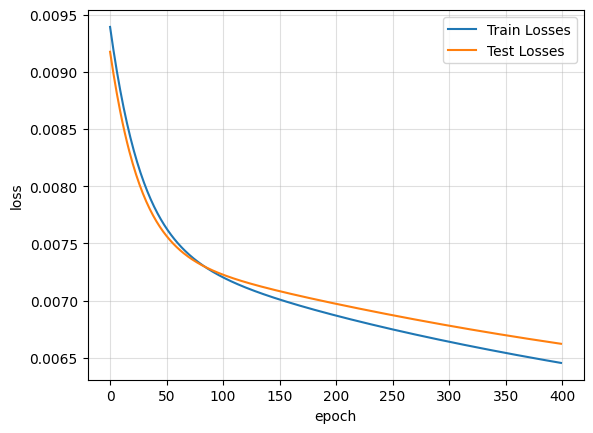

In [441]:
# 损失曲线
plt.plot(list(range(0, num_epochs)), train_losses, label="Train Losses")
plt.plot(list(range(0, num_epochs)), test_losses, label="Test Losses")
plt.legend(loc='upper right')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.grid(visible=True, alpha=0.4)
plt.show()

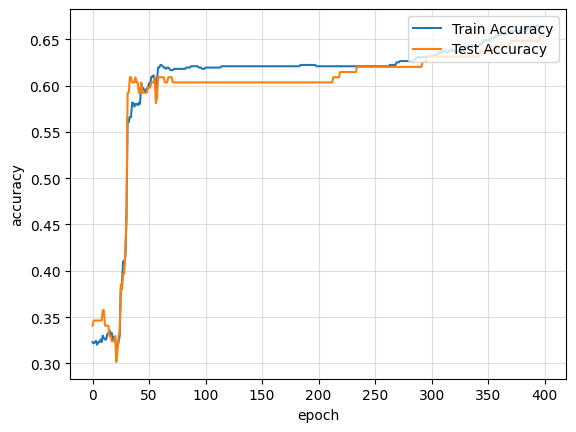

In [442]:
# 准确率曲线
plt.plot(list(range(0, num_epochs)), train_accuracy, label="Train Accuracy")
plt.plot(list(range(0, num_epochs)), test_accuracy, label="Test Accuracy")
plt.legend(loc='upper right')
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.grid(visible=True, alpha=0.4)
plt.show()